**Objective:** Calculate and visualize the velocity autocorrelation of fluid flow from PIV (Particle Image Velocimetry) data. The data is in a series of `.txt` files, with each file corresponding to a frame in time. 

**Procedure:**

1. **Data Preprocessing**:
    - Load the `.txt` file.
    - Convert the position and velocity data from meters and meters/second to micrometers and micrometers/second, respectively.
    - Retain only the converted columns: `x [um]`, `y [um]`, `u [um/s]`, and `v [um/s]`.

2. **Velocity Autocorrelation Calculation**:
    - For each frame, compute the velocity autocorrelation. There are two methods to do this:
        1. Using the `correlate2d` method from `scipy.signal`.
        2. Using Fourier transformations.
    - Normalize the velocities and handle any NaN values by replacing them with zeros.
    - Extract the radial form of the 2D autocorrelation.

3. **Exponential Fit**:
    - Fit the radial velocity autocorrelation to an exponential function.
    - Extract the correlation length, \( \lambda \), from the fit.
    - Plot the original data (radial autocorrelation) and the exponential fit on the same graph for comparison.

4. **Visualization**:
    - Plot the 2D autocorrelation for visualization.
    - Use a color map (e.g., 'viridis') for better visualization.
    - Add necessary labels, titles, and grids for clarity.

**Expected Results**: 
- A series of plots showing the velocity autocorrelation and its exponential fit for each frame.
- A visualization of the 2D autocorrelation for each frame.
- The correlation length, \( \lambda \), extracted from the fit.

**Note**: The procedures provided were based on a previous analysis. Ensure that the data structure, NaN handling, and any other specifics match the current dataset for accurate results.


# Data processing

In [1]:
import sys
sys.path.append('../../activedrops')
import autocorrelation

import pandas as pd
import numpy as np
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


First let's load our data and convert everything to microns.

In [2]:
link = "../../data/k401bio-250nM-piv/PIVlab_0051.txt"
# Load the data using the updated function
data_0001 = autocorrelation.load_and_convert_data(link)

data_0001

,x [um],y [um],u [um/s],v [um/s]
0,23.287672,23.287672,NaN,NaN
1,23.287672,45.205481,NaN,NaN
2,23.287672,67.123285,NaN,NaN
3,23.287672,89.041096,NaN,NaN
4,23.287672,110.958907,NaN,NaN
...,...,...,...,...
16124,2784.931567,2697.260352,NaN,NaN
16125,2784.931567,2719.178097,NaN,NaN
16126,2784.931567,2741.095843,NaN,NaN
16127,2784.931567,2763.013588,NaN,NaN


In [3]:
# def compute_velocity_autocorrelation_fourier(data):
#     """
#     Compute the spatial autocorrelation of the velocity field using Fourier transforms.
#     """
#     # Extracting the velocities
#     u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
#     v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

#     # Handle NaN values: replacing them with zero
#     u[np.isnan(u)] = 0
#     v[np.isnan(v)] = 0

#     # Normalizing the velocities
#     u_norm = u - np.mean(u)
#     v_norm = v - np.mean(v)

#     # Fourier transform of the normalized velocities
#     F_u_norm = np.fft.fft2(u_norm)
#     F_v_norm = np.fft.fft2(v_norm)
    
#     # Power spectrum
#     power_spectrum_u = np.abs(F_u_norm)**2
#     power_spectrum_v = np.abs(F_v_norm)**2
    
#     # Inverse Fourier transform of the power spectrum gives the autocorrelation
#     R_u = np.fft.ifft2(power_spectrum_u).real
#     R_v = np.fft.ifft2(power_spectrum_v).real
    
#     # Shift the result to have zero at the center
#     R_u = np.fft.fftshift(R_u)
#     R_v = np.fft.fftshift(R_v)

#     R_uv = np.dot(R_u, R_v)
    
#     return R_u, R_v, R_uv

# # Compute the 2D velocity autocorrelation using Fourier method
# R_u_fourier, R_v_fourier, R_uv_fourier = compute_velocity_autocorrelation_fourier(data_0001)


In [4]:
def compute_velocity_autocorrelation_fourier(data):
    """
    Compute the spatial autocorrelation of the velocity magnitude using Fourier transforms and normalize it.
    """
    # Extracting the velocities
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Handle NaN values: replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Compute the magnitude of the velocity
    magnitude = np.sqrt(u**2 + v**2)

    # Normalizing the velocity magnitude
    magnitude_norm = magnitude #- np.mean(magnitude)

    # Fourier transform of the normalized velocity magnitude
    F_magnitude_norm = np.fft.fft2(magnitude_norm)
    
    # Power spectrum of the magnitude
    power_spectrum_magnitude = np.abs(F_magnitude_norm)**2
    
    # Inverse Fourier transform of the power spectrum gives the autocorrelation
    R_magnitude = np.fft.ifft2(power_spectrum_magnitude).real
    
    # Shift the result to have zero at the center
    R_magnitude = np.fft.fftshift(R_magnitude)
    
    # Normalize the autocorrelation function by its value at zero lag
    center_x, center_y = R_magnitude.shape[0] // 2, R_magnitude.shape[1] // 2
    R_magnitude = R_magnitude / R_magnitude[center_x, center_y]
    
    return R_magnitude

# Compute and normalize the 2D velocity magnitude autocorrelation using Fourier method
R_magnitude_fourier = compute_velocity_autocorrelation_fourier(data_0001)


In [5]:
# # Visualization
# plt.figure(figsize=(10, 8))
# plt.imshow(R_uv_fourier, cmap='viridis', origin='lower', extent=[-R_uv_fourier.shape[1]//2, R_uv_fourier.shape[1]//2, -R_uv_fourier.shape[0]//2, R_uv_fourier.shape[0]//2])
# plt.colorbar(label="Autocorrelation Value")
# plt.title("2D Velocity Autocorrelation (Fourier Method) - u Component")
# plt.xlabel("Spatial Lag in x-direction (microns)")
# plt.ylabel("Spatial Lag in y-direction (microns)")
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# plt.show()


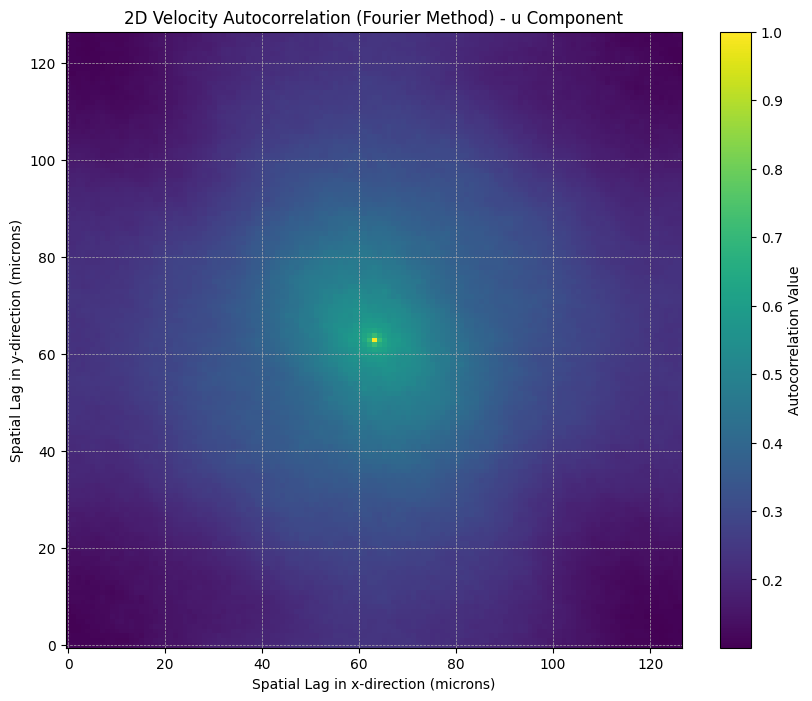

In [6]:
# Visualization
plt.figure(figsize=(10, 8))
plt.imshow(R_magnitude_fourier, cmap='viridis', origin='lower')#, extent=[-R_magnitude_fourier.shape[1]//2, R_magnitude_fourier.shape[1]//2, -R_magnitude_fourier.shape[0]//2, R_magnitude_fourier.shape[0]//2])
plt.colorbar(label="Autocorrelation Value")
plt.title("2D Velocity Autocorrelation (Fourier Method) - u Component")
plt.xlabel("Spatial Lag in x-direction (microns)")
plt.ylabel("Spatial Lag in y-direction (microns)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [7]:
def radial_velocity_autocorrelation(R):
    """
    Extract the radial form of a 2D autocorrelation matrix.
    
    Parameters:
    - R (ndarray): 2D autocorrelation matrix.
    
    Returns:
    - radial_mean (ndarray): Radial average of the autocorrelation matrix.
    """
    
    # Creating coordinate grids for the matrix
    y, x = np.indices((R.shape))
    
    # Computing the radial coordinate for each grid point
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    
    # Computing the radial average of the matrix
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean


def exponential_fit(r, A, B, C):
    """
    Exponential function for fitting purposes.
    
    Parameters:
    - r (ndarray): Radial distances.
    - A, B, C (float): Parameters of the exponential function.
    
    Returns:
    - ndarray: Values of the exponential function for the given radial distances.
    """
    return A * np.exp(-r / B) + C


def fit_and_extract_lambda(distances, radial_velocity, p0):
    """
    Fit the radial velocity autocorrelation to an exponential function and extract lambda.
    
    Parameters:
    - distances (ndarray): Radial distances.
    - radial_velocity (ndarray): Radial velocity autocorrelation.
    - p0 (list): Initial guesses for the fitting parameters [A, B, C].
    
    Returns:
    - lambda_val (float): Extracted correlation length.
    """
    
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=p0)
    
    # Extracting the correlation length lambda from the fit parameters
    A, B, C = popt
    lambda_val = -B * np.log((0.3 - C) / A)
    
    return lambda_val


def plot_exponential_fit(distances, radial_velocity, p0):
    """
    Fit the radial velocity autocorrelation to the exponential function with updated initial guesses and plot.
    
    Parameters:
    - distances (ndarray): Radial distances.
    - radial_velocity (ndarray): Radial velocity autocorrelation.
    - p0 (list): Initial guesses for the fitting parameters [A, B, C].
    """
    
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=p0)
    
    # Generating the exponential curve using the fitted parameters
    fitted_curve = exponential_fit(distances, *popt)
    
    # Plotting the original data and the fit
    plt.figure(figsize=(12, 6))
    plt.plot(distances, radial_velocity, 'b-', label="Original Data")
    plt.plot(distances, fitted_curve, 'r--', label="Exponential Fit")
    plt.xlabel("Distance (in microns)")
    plt.ylabel("Velocity Autocorrelation")
    plt.title("Velocity Autocorrelation and Exponential Fit with Updated Initial Guesses")
    plt.legend()
    plt.grid(True)
    plt.show()


In [8]:
# Extract the radial autocorrelation
radial_autocorr_fourier = radial_velocity_autocorrelation(R_magnitude_fourier)

# Adjusting the distances array to match the size of the radial_autocorr_fourier
distances_fourier = np.arange(len(radial_autocorr_fourier))

In [9]:
# Initial guesses based on the observations
A_initial = np.max(radial_autocorr_fourier)
B_initial = distances_fourier[np.abs(radial_autocorr_fourier - 0.5 * A_initial).argmin()]
C_initial = radial_autocorr_fourier[-1]
# Updated initial guesses for the fitting parameters
p0 = [A_initial, B_initial, C_initial]

# Fit the radial autocorrelation to the exponential function to extract the correlation length
correlation_length_fourier = fit_and_extract_lambda(distances_fourier, radial_autocorr_fourier, p0=p0)

correlation_length_fourier


36.436119244139654


**Adjusting Initial Guesses**:
   - For \( A \) (the amplitude of the exponential function): I chose the maximum value of the radial autocorrelation. This is because the autocorrelation starts from this high value.
   - For \( B \) (related to the decay rate of the exponential function): I approximated the distance at which the autocorrelation drops to half its initial value. This gives an estimate of how quickly the autocorrelation decays.
   - For \( C \) (the constant offset in the exponential function): I chose the value of the radial autocorrelation at the largest distance, as the data seems to asymptotically approach this non-zero value.


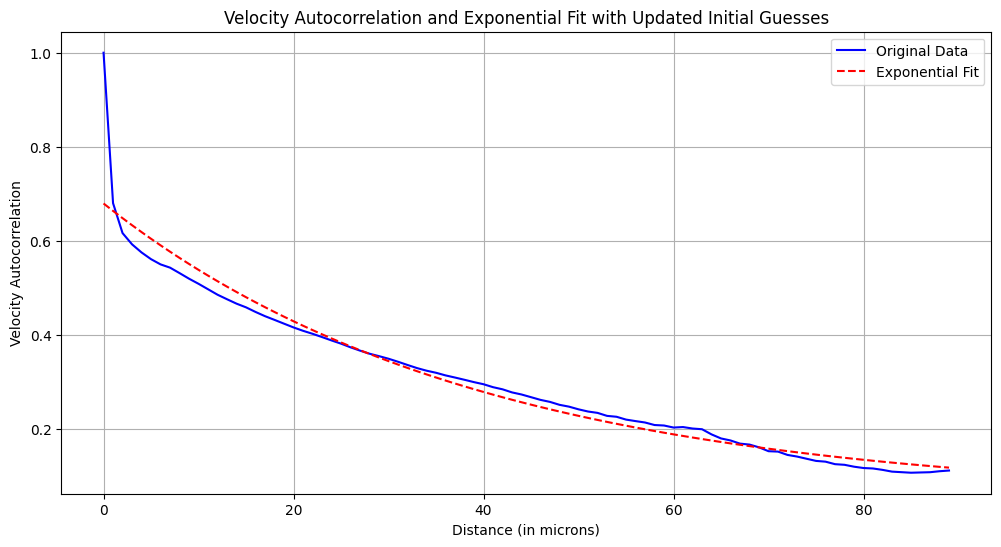

In [10]:
# Initial guesses based on the observations
A_initial = np.max(radial_autocorr_fourier)
B_initial = distances_fourier[np.abs(radial_autocorr_fourier - 0.5 * A_initial).argmin()]
C_initial = radial_autocorr_fourier[-1]

# Updated initial guesses for the fitting parameters
p0_updated = [A_initial, B_initial, C_initial]

# Plotting the exponential fit using the updated initial guesses
def plot_exponential_fit_updated(distances, radial_velocity, p0):
    """
    Fit the radial velocity autocorrelation to the exponential function with updated initial guesses and plot.
    """
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=p0)
    
    # Generating the exponential curve using the fitted parameters
    fitted_curve = exponential_fit(distances, *popt)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(distances, radial_velocity, 'b-', label="Original Data")
    plt.plot(distances, fitted_curve, 'r--', label="Exponential Fit")
    plt.xlabel("Distance (in microns)")
    plt.ylabel("Velocity Autocorrelation")
    plt.title("Velocity Autocorrelation and Exponential Fit with Updated Initial Guesses")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting with updated initial guesses
plot_exponential_fit_updated(distances_fourier, radial_autocorr_fourier, p0_updated)
